In [1]:
import findspark
findspark.init('/Users/sofia/spark')

In [2]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
import re
import time
import numpy as np
from collections import namedtuple
from IPython import display
from PIL import Image
from os import path, getcwd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

'''
Add the new values of counts with the previous running count to get the latest running count
'''  
def updateFunction(newValues, runningCount):
    if runningCount is None:
        runningCount = 0
    return sum(newValues, runningCount)  

**Capturing the Tweet Stream**

In [3]:
sc = SparkContext()
'''
Create a StreamingContext with batch interval of 10 seconds
'''
ssc = StreamingContext(sc, 10)
ssc.checkpoint('twitterStreamCheckpoint')

sqlContext = SQLContext(sc)

def getWordList(fileName):
    ''' 
    This function returns a list of words from the given file name.
    '''
    lines = sc.textFile(fileName)
    '''
    Filtering blank lines and lines that start with ';' from the input file
    '''
    lines=lines.filter(lambda line : line and line[0].isalpha())
    words = lines.flatMap(lambda line:line.split('\n'))
    return words.collect()

'''
Creating positive and negative word list using getWordList function.
'''
positiveWordsList = getWordList('positive_words.txt')
negativeWordsList = getWordList('negative_words.txt')


socketStream = ssc.socketTextStream('127.0.0.1', 9999)
tweets = socketStream.window(20)

**Trending HashTag Counts**

In [4]:
'''
Split tweets in to a list of words
'''
words = tweets.flatMap(lambda tweet:tweet.split(' '))

fields = ('hashtag', 'count')
tweet = namedtuple('tweet', fields)

'''
Checking for hashtags
'''
filteredWords=words.filter(lambda word: re.findall(r'#(\w+)', word))
'''
Key value pair creation with key as lower cased word
'''
hashtagPairs=filteredWords.map(lambda word: (word.lower(),1))
'''
Reduce process, taking running count of hashtag
'''
runningHashtagCounts=hashtagPairs.updateStateByKey(updateFunction) 
'''
Stores in a namedtuple Object named tweet
'''
runningHashtagCountsRec=runningHashtagCounts.map(lambda record: tweet(record[0], record[1])) 
'''
Sorting them in a DF and Registering to a table.
'''
(runningHashtagCountsRec.foreachRDD(lambda rdd: rdd.toDF().sort(desc('count')) 
  .limit(10).registerTempTable('tweetHashtags'))) 

#### Shown below are the counts of all positive and negative words in the tweets. Also listing of positive and Negetive words

In [5]:
'''
Counting of all the positive and negative words in tweets
'''
positivePairs = words.map(lambda word: ('Positive', 1) if word.lower() in positiveWordsList else ('Positive', 0))
negativePairs = words.map(lambda word: ('Negative', 1) if word.lower() in negativeWordsList else ('Negative', 0))
allSentiments = positivePairs.union(negativePairs)
sentimentCounts = allSentiments.reduceByKey(lambda x,y: x+y)
'''
Printing Running Total of positive and negative word
'''
runningCounts = sentimentCounts.updateStateByKey(updateFunction)
runningCounts.pprint()
    
'''
Here, countList cretaed in above steps looks like:
[[('Positive', 5), ('Negative', 2)], [('Positive', 14), ('Negative', 1)], ....]

Using the foreachRDD function countList variable holds the positive and negative word counts for all time steps.
'''
countList = []
sentimentCounts.foreachRDD(lambda t,rdd: countList.append(rdd.collect()))

'''
Listing positive negative word for creating Wordcloud
'''
positiveWordPairs = words.map(lambda word: ('PositiveWords', [word.lower()]) if word.lower() in positiveWordsList else ('PositiveWords', []))
negativeWordPairs = words.map(lambda word: ('NegativeWords', [word.lower()]) if word.lower() in negativeWordsList else ('NegativeWords', []))
allWordSentiments = positiveWordPairs.union(negativeWordPairs)
sentimentWords = allWordSentiments.reduceByKey(lambda x,y: x+y)
'''
Remove empty strings from the value part of the tuple. Value of the Pair is list of word.
'''
sentimentWords=sentimentWords.mapValues(lambda x : list(filter(None, x)))

'''
Here, sentimentWordList created in above steps looks like:
[[('PositiveWords', ['won', 'gain', 'win', 'important', 'wow']),
  ('NegativeWords', ['worst', 'abuse'])],
 [('PositiveWords',
   ['winner','luck','gem','greate','thank','super','welcome','top','lucky','nice','easy','best',
    'right','good']),
  ('NegativeWords', ['crash'])]....]
Using the foreachRDD function sentimentWordList variable holds the list of positive and negative words for
all time steps.
'''

sentimentWordList = []
sentimentWords.foreachRDD(lambda t,rdd: sentimentWordList.append(rdd.collect()))

'''
Start the computation
'''
ssc.start()

-------------------------------------------
Time: 2019-11-22 15:38:30
-------------------------------------------

-------------------------------------------
Time: 2019-11-22 15:38:40
-------------------------------------------
('Positive', 4)
('Negative', 1)

-------------------------------------------
Time: 2019-11-22 15:38:50
-------------------------------------------
('Positive', 8)
('Negative', 2)

-------------------------------------------
Time: 2019-11-22 15:39:00
-------------------------------------------
('Positive', 13)
('Negative', 2)

-------------------------------------------
Time: 2019-11-22 15:39:10
-------------------------------------------
('Positive', 18)
('Negative', 2)

-------------------------------------------
Time: 2019-11-22 15:39:20
-------------------------------------------
('Positive', 28)
('Negative', 7)

-------------------------------------------
Time: 2019-11-22 15:39:30
-------------------------------------------
('Positive', 42)
('Negative', 16)

### Plot displaying comparative tweet counts for top ten trending topical twitter hashtags

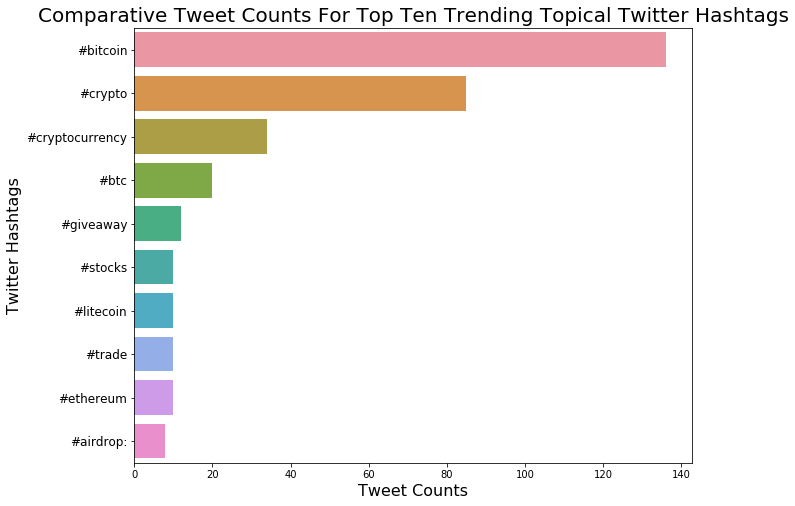

In [6]:
count = 0
sns.set_palette('husl')
while count < 10:
    
    time.sleep(3)
    topTenTweets = sqlContext.sql('select hashtag, count from tweetHashtags')
    topTenDF = topTenTweets.toPandas()
    display.clear_output(wait=True)
    plt.figure(figsize=(10,8))
    sns.barplot(x='count', y='hashtag', data=topTenDF)
    plt.title('Comparative Tweet Counts For Top Ten Trending Topical Twitter Hashtags', fontsize=20)
    plt.xlabel('Tweet Counts', fontsize=16)
    plt.setp(plt.gca().get_yticklabels(), fontsize=12)
    plt.ylabel('Twitter Hashtags', fontsize=16)
    plt.show()
    count = count + 1

In [7]:
ssc.stop(stopGraceFully=True)

-------------------------------------------
Time: 2019-11-22 15:46:20
-------------------------------------------
('Positive', 284)
('Negative', 108)

-------------------------------------------
Time: 2019-11-22 15:46:30
-------------------------------------------
('Positive', 284)
('Negative', 108)



### Plot showing tweet stream sentiment flow

In [8]:
positiveWordCounts=[]
negativeWordCounts=[]

def plotTweetStreamSentimentFlow(countLst):
    '''
    Plot Tweet Stream Sentiment Flow using the count for the positive and negative words for each timestep.
    '''
    for countInEachTimeStep in countLst:
        if countInEachTimeStep!=[]:
            positiveWordCounts.append(countInEachTimeStep[0][1])
            negativeWordCounts.append(countInEachTimeStep[1][1])
               
    '''
    As each of the sublist of countList contains the same number of tuple for positive and negative word count.
    positiveWordCounts and negativeWordCounts list have same lenth. 
    Taking the range() of any of the said list's len() give the time steps.
    '''
    timeStep=list(range(len(positiveWordCounts)))
    
    plt.figure(figsize=(15,8))
    plt.title('***Time Step VS Word Count In Twitter Streaming***', fontsize=18)
    plt.plot(timeStep,positiveWordCounts,'go-',label='Positive')
    plt.plot(timeStep,negativeWordCounts,'bo-',label='Negative')
    plt.xlabel('Time step', fontsize=16)
    plt.ylabel('Word count', fontsize=16)
    plt.legend(loc='upper left')
    plt.show()

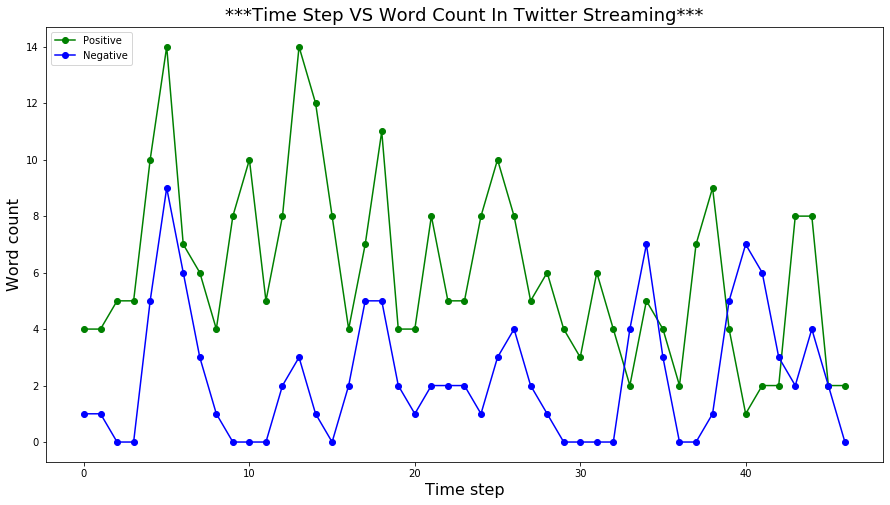

In [9]:
plotTweetStreamSentimentFlow(countList)

### Plot showing wordclouds of positive and negative words from Tweets

In [10]:
def getWordCloud(wordList,color,img):
    directory = getcwd()
    mask = np.array(Image.open(path.join(directory, img)))
    stopWords = set(STOPWORDS)
    allWords = ' '.join([word for word in set(wordList)])
    wordCloud = WordCloud(background_color=color,
                          stopwords=stopWords,
                          width=1600,
                          height=800,
                          random_state=21,
                          max_words=50,
                          max_font_size=200,
                          mask=mask,
                          contour_width=3, 
                          contour_color='skyblue').generate(allWords)
    
    plt.figure(figsize=(15, 10))
    plt.axis('off')
    plt.imshow(wordCloud, interpolation='bilinear')

positiveWords=[]
negativeWords=[]

def generateWordClouds(sentimentWordLst):
    '''
    Plot wordclouds of positive and negative words.
    '''
    for wordInEachTimeStep in sentimentWordLst:
        if wordInEachTimeStep!=[]:
            positiveWords.extend(wordInEachTimeStep[0][1])
            negativeWords.extend(wordInEachTimeStep[1][1])
 
                
    if len(positiveWords) > 1 :
        getWordCloud(positiveWords,'white','img/thumbs_up.png')
    if len(negativeWords) > 1 :
        getWordCloud(negativeWords,'black','img/thumbs_down.png')
    

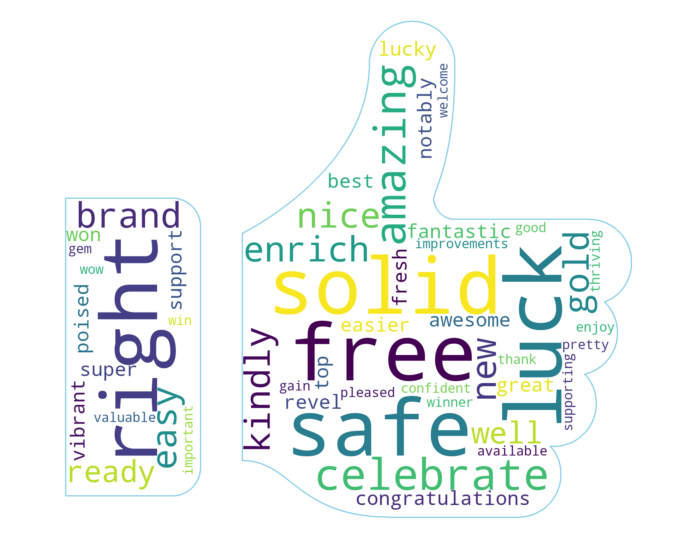

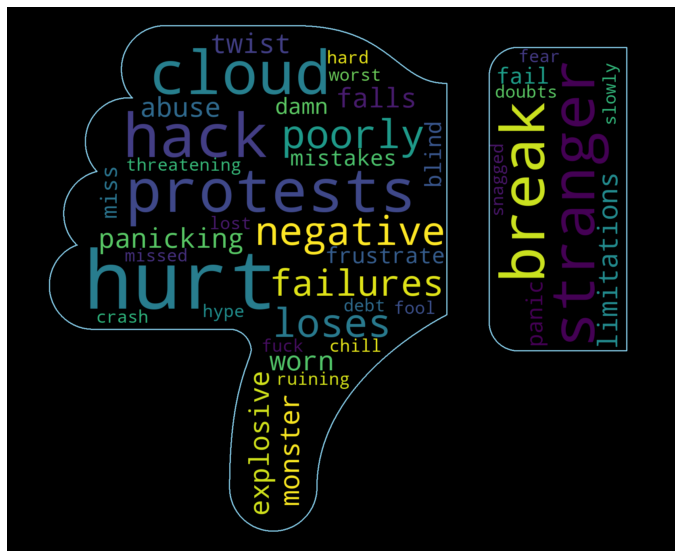

In [11]:
generateWordClouds(sentimentWordList)